In [58]:
import numpy as np
import matplotlib.pyplot as plt 

In [59]:
#simualte Geometric Brownian Motion
mu = 0.1 # drift term
r = 0.05 # risk-free rate
sigma = 0.2 # volatility
S0 = 100 # initial stock price
T = 1/2 # time horizon in years

In [60]:
def generate_GBM(mu , sig , S0 , T , r , n , N ):
    dt = T/n # time step
    S = np.zeros((N,n+1)) # array to hold stock prices
    S[:,0] = S0 # set initial stock price
    for i in range(n):
        Z = np.random.normal(0, 1, N) # generate standard normal random variables
        S[:,i+1] = S[:,i] * np.exp((mu - 0.5*sig**2)*dt + sig*np.sqrt(dt)*Z) # update stock prices
    return S

In [61]:
# REAL MEAsURE  
Real = generate_GBM(mu , sigma , S0 , T , r , 1000 , 10 ) # generate stock prices

In [62]:
def plot_GBM(S, T, n):
    plt.figure(figsize=(10, 6))
    for i in range(n):
        plt.plot(np.linspace(0, T, S.shape[1]), S[i], lw=1)
    plt.title('Geometric Brownian Motion')  
    plt.legend(['Path {}'.format(i) for i in range(n)]) 
    plt.xlabel('Time (years)')
    plt.ylabel('Stock Price')   
    plt.show()

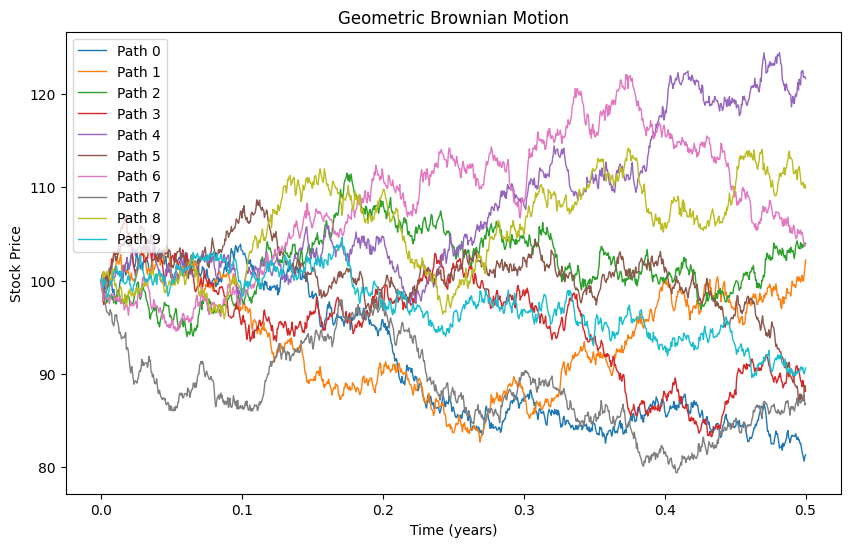

In [63]:
plot_GBM(Real, T, 10) # plot the generated paths

In [64]:
#Risk neutral measure
Mart = generate_GBM(r , sigma , S0 , T , r , 1000 , 10 ) # generate stock prices under risk-neutral measure

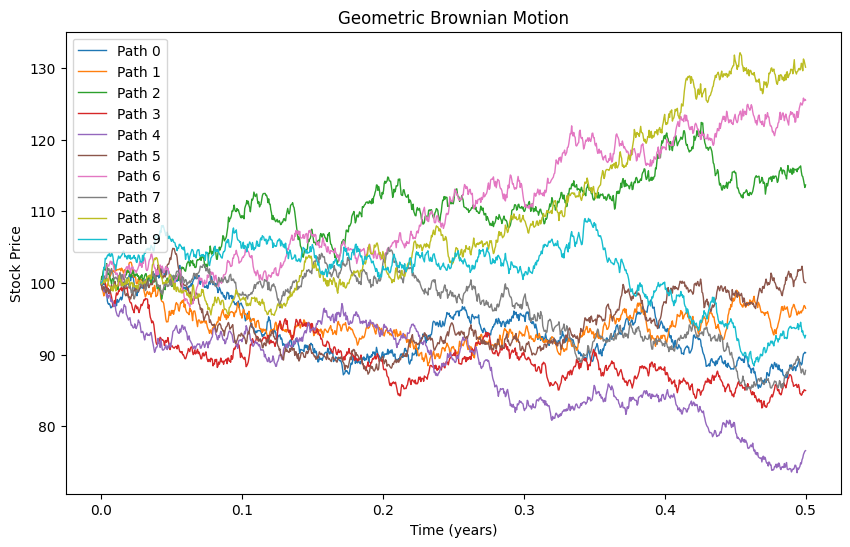

In [65]:
plot_GBM(Mart, T, 10) 

In [66]:
#Monte Carlo Methods for Arithmetic Average Asian Options 
def asiancall_option(r , sig  , s0 , T , K , N , n):
    sum = 0 
    t = T/(N-1)
    for i in range(n):
        loc_sum = 0
        lazt = s0 
        for i in range(N):
            if(i==0):
                loc_sum +=s0 
            else:
                lazt= lazt * np.exp((r - 0.5*sig**2)*t + sig*np.sqrt(t)*np.random.normal(0,1))
                loc_sum+=lazt
        sum += max(0 , loc_sum/N - K) 
    return np.exp(-r*T) * sum/n
def asianput_option(r , sig  , s0 , T , K , N , n):
    sum = 0 
    t = T/(N-1)
    for i in range(n):
        loc_sum = 0
        lazt = s0 
        for i in range(N):
            if(i==0):
                loc_sum +=s0 
            else:
                lazt= lazt * np.exp((r - 0.5*sig**2)*t + sig*np.sqrt(t)*np.random.normal(0,1))
                loc_sum+=lazt
        sum += max(0 , K-loc_sum/N ) 
    return np.exp(-r*T) * sum/n


In [67]:
asian_option_price = asiancall_option(r , sigma , S0 , T , 105 , 1000 , 1000 ) #k=105
asian_option_price1 = asiancall_option(r , sigma , S0 , T , 110 , 1000 , 1000 ) #k = 110
asian_option_price2 = asiancall_option(r , sigma , S0 , T , 90 , 1000 , 1000 ) #k = 90
asian_option_pricep = asianput_option(r , sigma , S0 , T , 105 , 1000 , 1000 ) #k=105
asian_option_pricep1 = asianput_option(r , sigma , S0 , T , 110 , 1000 , 1000 ) #k = 110
asian_option_pricep2 = asianput_option(r , sigma , S0 , T , 90 , 1000 , 1000 ) #k = 90

In [68]:
print(f" monte carlo method for arithmetic avg asian option give price {asian_option_price} for call at K = 105 ")
print(f" monte carlo method for arithmetic avg asian option give price {asian_option_price1} for call at K = 110")
print(f" monte carlo method for arithmetic avg asian option give price {asian_option_price2} for call at K = 90")
print(f" monte carlo method for arithmetic avg asian option give price {asian_option_pricep} for put at K = 105 ")
print(f" monte carlo method for arithmetic avg asian option give price {asian_option_pricep1} for put at K = 110")
print(f" monte carlo method for arithmetic avg asian option give price {asian_option_pricep2} for put at K = 90")

 monte carlo method for arithmetic avg asian option give price 1.943145796949053 for call at K = 105 
 monte carlo method for arithmetic avg asian option give price 0.7976940050109058 for call at K = 110
 monte carlo method for arithmetic avg asian option give price 10.775697881316951 for call at K = 90
 monte carlo method for arithmetic avg asian option give price 5.481805792354001 for put at K = 105 
 monte carlo method for arithmetic avg asian option give price 9.23941393628981 for put at K = 110
 monte carlo method for arithmetic avg asian option give price 0.2887347183424864 for put at K = 90


In [69]:
from scipy.stats import norm
import numpy as np

# Black-Scholes price of a European Call
def bs_call_price(s0, K, T, r, sig):
    d1 = (np.log(s0/K) + (r + 0.5*sig**2)*T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    return s0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# Asian Call with control variate using optimal coefficient c
def asiancall_control_variate(r , sig  , s0 , T , K , N , n):
    dt = T/(N-1)
    asian_payoffs = []
    euro_payoffs = []
    
    for _ in range(n):
        path = [s0]
        for _ in range(1, N):
            next_s = path[-1] * np.exp((r - 0.5*sig**2)*dt + sig*np.sqrt(dt)*np.random.normal(0,1))
            path.append(next_s)
        average_price = np.mean(path)
        ST = path[-1]
        asian_payoff = max(0, average_price - K)
        euro_payoff = max(0, ST - K)
        asian_payoffs.append(asian_payoff)
        euro_payoffs.append(euro_payoff)
    
    asian_payoffs = np.array(asian_payoffs)
    euro_payoffs = np.array(euro_payoffs)
    
    cov = np.cov(asian_payoffs, euro_payoffs, ddof=1)[0,1]
    var = np.var(euro_payoffs, ddof=1)
    c = cov / var if var > 0 else 0

    euro_analytic = bs_call_price(s0, K, T, r, sig)

    control_variate_estimate = asian_payoffs + c * (euro_analytic - euro_payoffs)
    price = np.exp(-r*T) * np.mean(control_variate_estimate)
    return price


def bs_put_price(s0, K, T, r, sig):
    d1 = (np.log(s0/K) + (r + 0.5*sig**2)*T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    return K * np.exp(-r*T) * norm.cdf(-d2) - s0 * norm.cdf(-d1)

def asianput_control_variate(r , sig  , s0 , T , K , N , n):
    dt = T/(N-1)
    asian_payoffs = []
    euro_payoffs = []
    
    for _ in range(n):
        path = [s0]
        for _ in range(1, N):
            next_s = path[-1] * np.exp((r - 0.5*sig**2)*dt + sig*np.sqrt(dt)*np.random.normal(0,1))
            path.append(next_s)
        average_price = np.mean(path)
        ST = path[-1]
        asian_payoff = max(0, K - average_price)
        euro_payoff = max(0, K - ST)
        asian_payoffs.append(asian_payoff)
        euro_payoffs.append(euro_payoff)
    
    asian_payoffs = np.array(asian_payoffs)
    euro_payoffs = np.array(euro_payoffs)
    
    cov = np.cov(asian_payoffs, euro_payoffs, ddof=1)[0,1]
    var = np.var(euro_payoffs, ddof=1)
    c = cov / var if var > 0 else 0  # Avoid divide by zero

    euro_analytic = bs_put_price(s0, K, T, r, sig)
    
    control_variate_estimate = asian_payoffs + c * (euro_analytic - euro_payoffs)
    price = np.exp(-r*T) * np.mean(control_variate_estimate)
    return price

In [70]:
A1 = asiancall_control_variate(r , sigma , S0 , T , 105 , 1000 , 1000 ) #k=105
A2 = asiancall_control_variate(r , sigma , S0 , T , 110 , 1000 , 1000 ) #k=110
A3 = asiancall_control_variate(r , sigma , S0 , T , 90 , 1000 , 1000 ) #k=90
B1 = asianput_control_variate(r , sigma , S0 , T , 105 , 1000 , 1000 ) #k=105
B2 = asianput_control_variate(r , sigma , S0 , T , 110 , 1000 , 1000 ) #k=110
B3 = asianput_control_variate(r , sigma , S0 , T , 90 , 1000 , 1000 ) #k=90

In [71]:
print(f" monte carlo method for arithmetic avg asian option give price {A1} for call at K = 105 ")
print(f" monte carlo method for arithmetic avg asian option give price {A2} for call at K = 110")
print(f" monte carlo method for arithmetic avg asian option give price {A3} for call at K = 90")
print(f" monte carlo method for arithmetic avg asian option give price {B1} for put at K = 105 ")
print(f" monte carlo method for arithmetic avg asian option give price {B2} for put at K = 110")
print(f" monte carlo method for arithmetic avg asian option give price {B3} for put at K = 90")

 monte carlo method for arithmetic avg asian option give price 1.809969159011099 for call at K = 105 
 monte carlo method for arithmetic avg asian option give price 0.6683347759285786 for call at K = 110
 monte carlo method for arithmetic avg asian option give price 10.959852782679224 for call at K = 90
 monte carlo method for arithmetic avg asian option give price 5.306028667743607 for put at K = 105 
 monte carlo method for arithmetic avg asian option give price 9.127861475628045 for put at K = 110
 monte carlo method for arithmetic avg asian option give price 0.26272482862042795 for put at K = 90
